# Install Qiskit ignis

In [1]:
!git clone https://github.com/Qiskit/qiskit-ignis.git

fatal: destination path 'qiskit-ignis' already exists and is not an empty directory.


In [2]:
!pip install -e qiskit-ignis

Obtaining file:///Users/mamico/qiskit-ignis
  Found existing installation: qiskit-ignis 0.1.0
    Uninstalling qiskit-ignis-0.1.0:
      Successfully uninstalled qiskit-ignis-0.1.0
  Running setup.py develop for qiskit-ignis
You are using pip version 19.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Imports

In [3]:
import sys
sys.path.append('qiskit-ignis/qiskit')
import numpy as np
import time
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, BasicAer
from qiskit.quantum_info import state_fidelity
import qiskit.ignis.verification.tomography as tomo
from qiskit.tools.visualization import plot_state_city
import matplotlib.pyplot as plt

/anaconda/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


# Functions for Bayesian tomography

In [4]:
def bme_fit(probs, basis_matrix, shots):

    N = int(np.sqrt(basis_matrix[0].shape[0]))
    SAMPLES = 400

    def logl(rho, meas_res):

        logl = 0.0
        for result in meas_res:
            logl += result[1] * np.log(np.real(np.trace(np.matmul(np.reshape(result[0], (N,N)), rho))))

        return logl

    def montecarlo(N, likelihood, nsamples):
        result = np.zeros((N, N), dtype='complex')
        error = np.kron(result, result)

        # Estimated density operator
        for i in range(nsamples):
            rho = ginibre(N)
            L = np.exp(likelihood(rho))
            result += L * rho
            error += L * np.kron(rho, rho)

        result /= nsamples
        trace = np.trace(result)
        result /= trace

        error /= nsamples
        error /= trace
        error -= np.kron(result, result)

        return result, error


    # print(basis_matrix)
    # print(probs)

    counts = [i * shots for i in probs]

    # print(counts)

    meas_res = list(zip(basis_matrix,counts)) 

    res = montecarlo(N, lambda rho: logl(rho, meas_res), SAMPLES)
    return res

def compute_std_error(obs, superoperator):
   return np.sqrt(np.trace(np.matmul(np.kron(obs,obs),superoperator))).real

# From QuTiP
def ginibre(N, rank=None):
   """
   Returns a Ginibre random density operator of dimension
   ``dim`` and rank ``rank`` by using the algorithm of
   [BCSZ08]_. If ``rank`` is `None`, a full-rank
   (Hilbert-Schmidt ensemble) random density operator will be
   returned.
   Parameters
   ----------
   N : int
       Dimension of the density operator to be returned.
   rank : int or None
       Rank of the sampled density operator. If None, a full-rank
       density operator is generated.
   Returns
   -------
   rho : Qobj
       An N × N density operator sampled from the Ginibre
       or Hilbert-Schmidt distribution.
   """
   if rank is None:
       rank = N
   if rank > N:
       raise ValueError("Rank cannot exceed dimension.")
   shape = (N, rank)
   X = np.sum(np.random.randn(*(shape + (2,)))* np.array([1, 1j]), axis=-1)
   rho = np.dot(X, X.T.conj())
   rho /= np.trace(rho)

   return rho

# Example

Bayesian methods of inference in the case of few trials give a more conservative estimate compared to frequentist approaches.
This avoids giving unphysical results, unacceptable in the experimental setting (e.g. some eigenvalues of the density matrix equal to 0).
Moreover, it allows to calculate errorbars for any observable.
The estimate is also robust in presence of error, as its not easily biased.

In [88]:
#number of trials
SHOTS = 5

#number of qubits
n = 1

#create a qubit register
q_reg = QuantumRegister(n)
c_reg = ClassicalRegister(n)

#create a quantum circuit
circuit = QuantumCircuit(q_reg)


#append gates to the quantum circuit
circuit.x(q_reg[0])

# print(circuit.qasm())

#run the circuit
job = qiskit.execute(circuit, BasicAer.get_backend('statevector_simulator'))

#get wave function at the end of the circuit
psi = job.result().get_statevector(circuit)
# print('final state of the circuit',psi)


# Generate circuits for tomography and run tomography on simulator
t = time.time()
qst = tomo.state_tomography_circuits(circuit, q_reg)
job = qiskit.execute(qst, BasicAer.get_backend('qasm_simulator'), shots=SHOTS)
# print('Time taken:', time.time() - t)

# Extract tomography data so that counts are indexed by measurement configuration
tomo_counts = tomo.tomography_data(job.result(), qst)

# Generate fitter data and reconstruct density matrix
probs, basis_matrix, weights = tomo.fitter_data(tomo_counts)
# print('tomography results',tomo_counts)

#bayesian reconstruction of the density matrix and error on observable
rho_fit, error_rho = bme_fit(probs, basis_matrix, SHOTS)

#maximum likelihood reconstruction of density matrix
rho_mle = tomo.state_mle_fit(probs, basis_matrix, weights)


print("Density matrix from maximum likelihood estimate:")
print(rho_mle)

print("Density matrix from Bayesian mean estimate")
print(rho_fit)

Density matrix from maximum likelihood estimate:
[[ 0.14992998+0.j         -0.070014  +0.35007002j]
 [-0.070014  -0.35007002j  0.85007002+0.j        ]]
Density matrix from Bayesian mean estimate
[[ 0.26406353+0.j         -0.06239763+0.23335801j]
 [-0.06239763-0.23335801j  0.73593647+0.j        ]]


# Maximum likelihood estimate of the density matrix

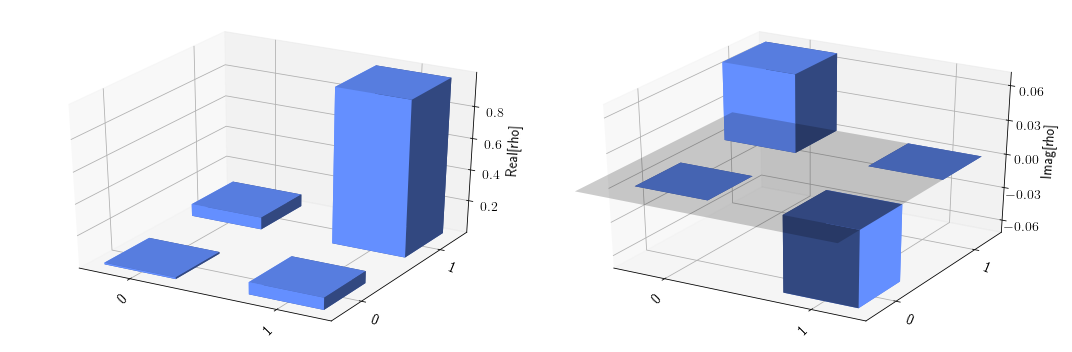

In [78]:
plot_state_city(rho_mle)

# Eigenvalues of the MLE of the density matrix

In [79]:
print(np.diag(np.linalg.eig(rho_mle)[0]))

[[4.90136281e-18+1.44297818e-18j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 1.00000000e+00-1.44297818e-18j]]


# Bayesian mean estimate of the density matrix

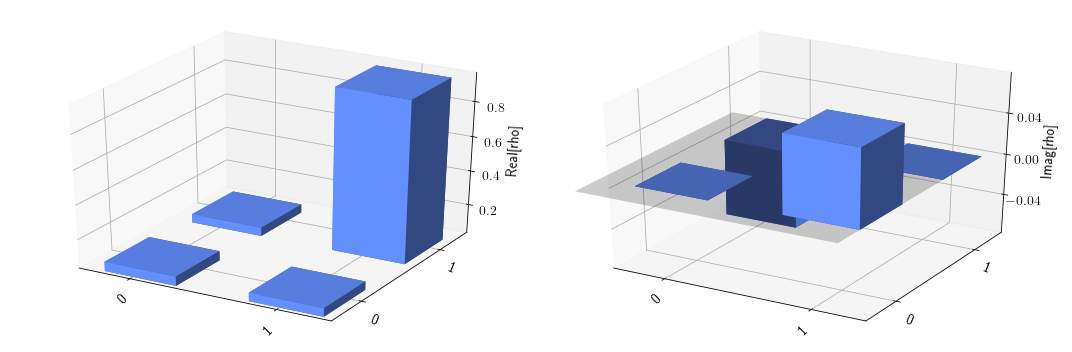

In [80]:
plot_state_city(rho_fit)

# Eigenvalues of the BME of the density matrix

In [82]:
print(np.diag(np.linalg.eig(rho_fit)[0]))

[[0.04617801-8.58983194e-19j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.95382199-2.21185622e-16j]]


# Errorbars on observables

[[-1  0]
 [ 0  1]]
(0.4718729418389115+0j)
0.254375845106676


/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


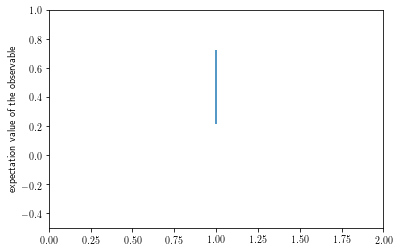

In [89]:
#choose observable
Z = np.array([[-1,0],[0,1]])
print(Z)

obs = Z

#compute expectation value
exp_obs = np.trace(np.matmul(Z,rho_fit))
print(exp_obs)


#compute errorbar on expectation value
err_obs = compute_std_error(obs, error_rho)
print(err_obs)

# plot expectation value with errorbar
plt.errorbar(1, exp_obs, yerr=err_obs, fmt='')
plt.xlim(0,2) 
plt.ylim(-0.5,1)
plt.ylabel('expectation value of the observable')
plt.show()